# DSCI552: HW6
#Part 2: Active Learning Using SVM


***Name: Cheng Peng***


***USC ID: 6898-9638-37***

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
import random

#A: Download Data 

In [ ]:
url = "/content/drive/My Drive/DSCI552/Homework 6 Data/data_banknote_authentication.txt"
columns = ["variance", "Skewness", "Curtosis", "Entropy", "Class"]
df = pd.read_csv(url, header=None, names=columns)

In [ ]:
df

,variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [ ]:
train, test = train_test_split(df, test_size = 472, random_state = 1)
train_x, train_y = train[columns[:-1]], train["Class"]
test_x, test_y = test[columns[:-1]], test["Class"]

In [ ]:
print("There are {} samples in the training set and {} samples in the test set".format(len(train_x), len(test_x)))

There are 900 samples in the training set and 472 samples in the test set


# B: Active Learning and Passive Learning 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def loadData():
    train, test = train_test_split(df, test_size = 472, random_state = 1)
    train_x, train_y = train[columns[:-1]], train["Class"]
    test_x, test_y = test[columns[:-1]], test["Class"]
    scaler = StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    train_x = pd.DataFrame(train_x)
    test_x = pd.DataFrame(test_x)
    return train_x, train_y, test_x, test_y

In [ ]:
def svm(train_x, train_y, test_x, test_y):
    model = LinearSVC(penalty='l1', dual = False)
    param = {"C": np.logspace(-1, 5, 10)}
    grid_search = GridSearchCV(model, param, cv=5).fit(train_x, train_y)
    train_predict = grid_search.predict(train_x)
    test_predict = grid_search.predict(test_x)
    train_error = 1 - accuracy_score(train_y, train_predict)
    test_error = 1- accuracy_score(test_y, test_predict)
    return train_error, test_error

In [ ]:
def passiveLearning():
    train_errors = []
    test_errors = [] 
    train_x, train_y, test_x, test_y = loadData()
    train_sub_x = pd.DataFrame()
    train_sub_y = pd.DataFrame()
    for i in range(90):
        if len(train_x) >10:
            train_x, sample_x, train_y, sample_y = train_test_split(train_x,train_y,test_size = 10)
            train_sub_x = pd.concat([train_sub_x, sample_x])
            train_sub_y = pd.concat([train_sub_y, sample_y])
        else: 
            train_sub_x = pd.concat([train_sub_x, train_x])
            train_sub_y = pd.concat([train_sub_y, train_y])
        if i%10 == 0:
            print("Training instance {}: training set size = {}".format(i, len(train_sub_x)))
        train_error, test_error = svm(train_sub_x, train_sub_y, test_x, test_y)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

        

In [ ]:
train_table = []
test_table = []
for i in range(50):
    print("Iteration {}:".format(i+1))
    train_errors, test_errors = passiveLearning()
    train_table.append(train_errors)
    test_table.append(test_errors)
    print("Train error = {:.4f}, test error = {:.4f}\n".format(train_errors[-1], test_errors[-1]))

Iteration 1:
Training instance 0: training set size = 10
Training instance 10: training set size = 110
Training instance 20: training set size = 210
Training instance 30: training set size = 310
Training instance 40: training set size = 410
Training instance 50: training set size = 510
Training instance 60: training set size = 610
Training instance 70: training set size = 710
Training instance 80: training set size = 810
Train error = 0.0100, test error = 0.0064

Iteration 2:
Training instance 0: training set size = 10
Training instance 10: training set size = 110
Training instance 20: training set size = 210
Training instance 30: training set size = 310
Training instance 40: training set size = 410
Training instance 50: training set size = 510
Training instance 60: training set size = 610
Training instance 70: training set size = 710
Training instance 80: training set size = 810
Train error = 0.0100, test error = 0.0085

Iteration 3:
Training instance 0: training set size = 10
Trainin

In [ ]:
passive_train = pd.DataFrame(train_table)
passive_test = pd.DataFrame(test_table)

In [ ]:
passive_mean = pd.concat([passive_train.agg(["mean"]), passive_test.agg(["mean"])])
passive_mean.index = ["Training Set", "Test Set"]

In [ ]:
passive_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
Training Set,0.016000,0.01800,0.012667,0.01250,0.010800,0.013000,0.014286,0.011250,0.009778,0.010000,0.006545,0.007500,0.007538,0.006429,0.007333,0.005750,0.005882,0.006556,0.006105,0.006200,0.00600,0.006455,0.005739,0.005167,0.005680,0.006462,0.006370,0.007000,0.006897,0.006600,0.006129,0.006750,0.007939,0.007706,0.007429,0.007333,0.007027,0.007316,0.007641,0.007500,...,0.008392,0.008231,0.008642,0.009259,0.009164,0.008750,0.008491,0.008552,0.008576,0.009000,0.009148,0.008839,0.008857,0.009344,0.009262,0.009424,0.009493,0.009294,0.009507,0.009229,0.009577,0.010028,0.010055,0.010297,0.009973,0.009947,0.009766,0.009615,0.009772,0.010050,0.009975,0.009976,0.009928,0.009810,0.010235,0.010233,0.010345,0.010205,0.010067,0.010000
Test Set,0.115847,0.07072,0.043475,0.03072,0.029873,0.027585,0.028644,0.025042,0.024831,0.023856,0.024449,0.023008,0.021059,0.021102,0.019831,0.020085,0.019237,0.018771,0.018136,0.017161,0.01661,0.017373,0.017712,0.016441,0.015127,0.016017,0.014915,0.014492,0.015042,0.014915,0.014492,0.014322,0.013517,0.012966,0.013136,0.012966,0.012415,0.012797,0.012797,0.012203,...,0.009958,0.009915,0.009746,0.010381,0.009746,0.009619,0.009534,0.009576,0.009492,0.009576,0.009661,0.009619,0.009492,0.009661,0.009703,0.009703,0.009703,0.009619,0.009322,0.009025,0.009068,0.008559,0.008686,0.008432,0.008136,0.008093,0.008051,0.008051,0.008136,0.008051,0.007881,0.007754,0.007754,0.007585,0.007712,0.007669,0.007373,0.007373,0.007246,0.007119


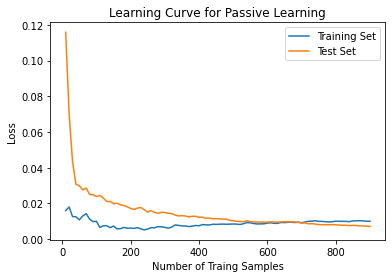

In [ ]:
plt.plot(np.linspace(10, 900, 90), passive_mean.iloc[0], label = "Training Set")
plt.plot(np.linspace(10, 900, 90), passive_mean.iloc[1], label = "Test Set")
plt.xlabel("Number of Traing Samples")
plt.ylabel("Loss")
plt.title("Learning Curve for Passive Learning")
plt.legend(loc="best")
plt.show()


In [ ]:
def activeLearning():
    train_errors = []
    test_errors = [] 
    train_x, train_y, test_x, test_y = loadData()
    train_sub_x = pd.DataFrame()
    train_sub_y = pd.DataFrame()
    for i in range(90):
        _, sample_x, _, sample_y = train_test_split(train_x,train_y,test_size = 10)
        train_sub_x = pd.concat([train_sub_x, sample_x])
        train_sub_y = pd.concat([train_sub_y, sample_y])
        if i%10 == 0:
            print("Training instance {}: training set size = {}".format(i, len(train_sub_x)))
        train_error, test_error = svm(train_sub_x, train_sub_y, test_x, test_y)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

In [ ]:
active_train_table = []
active_test_table = []
for i in range(50):
    print("Iteration {}:".format(i+1))
    train_errors, test_errors = activeLearning()
    active_train_table.append(train_errors)
    active_test_table.append(test_errors)
    print("Train error = {:.4f}, test error = {:.4f}\n".format(train_errors[-1], test_errors[-1]))

Iteration 1:
Training instance 0: training set size = 10
Training instance 10: training set size = 110
Training instance 20: training set size = 210
Training instance 30: training set size = 310
Training instance 40: training set size = 410
Training instance 50: training set size = 510
Training instance 60: training set size = 610
Training instance 70: training set size = 710
Training instance 80: training set size = 810
Train error = 0.0078, test error = 0.0085

Iteration 2:
Training instance 0: training set size = 10
Training instance 10: training set size = 110
Training instance 20: training set size = 210
Training instance 30: training set size = 310
Training instance 40: training set size = 410
Training instance 50: training set size = 510
Training instance 60: training set size = 610
Training instance 70: training set size = 710
Training instance 80: training set size = 810
Train error = 0.0044, test error = 0.0169

Iteration 3:
Training instance 0: training set size = 10
Trainin

In [ ]:
active_train = pd.DataFrame(active_train_table)
active_test = pd.DataFrame(active_test_table)
active_mean = pd.concat([active_train.agg(["mean"]), active_test.agg(["mean"])])
active_mean.index = ["Training Set", "Test Set"]
active_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
Training Set,0.016000,0.011000,0.009333,0.009500,0.01240,0.007667,0.008286,0.007750,0.005556,0.005400,0.007455,0.006167,0.0060,0.005714,0.0060,0.004500,0.004353,0.005333,0.005789,0.005400,0.005143,0.004364,0.004522,0.004250,0.005760,0.005000,0.004593,0.003929,0.003724,0.0036,0.004065,0.003438,0.003273,0.003235,0.003371,0.002944,0.003189,0.003158,0.003128,0.003350,...,0.004314,0.004615,0.004679,0.004704,0.005164,0.004750,0.005123,0.005172,0.005119,0.005300,0.005344,0.005581,0.005397,0.005406,0.005754,0.005485,0.005672,0.005706,0.005797,0.006400,0.006676,0.006667,0.006384,0.006568,0.006827,0.006947,0.006883,0.006923,0.006886,0.007100,0.007185,0.007366,0.007518,0.007500,0.007388,0.007372,0.007402,0.007568,0.007640,0.007600
Test Set,0.129788,0.065424,0.046907,0.035297,0.03161,0.027415,0.025805,0.025212,0.025381,0.026186,0.024576,0.024195,0.0225,0.021864,0.0225,0.020975,0.020085,0.020381,0.020763,0.019322,0.018941,0.019534,0.019110,0.017797,0.017415,0.016864,0.016398,0.015890,0.015000,0.0150,0.014873,0.014025,0.013517,0.013729,0.013475,0.013136,0.013644,0.013559,0.013432,0.013814,...,0.012542,0.012839,0.012585,0.012797,0.013008,0.012839,0.012839,0.012246,0.012288,0.012542,0.012627,0.012331,0.011737,0.012161,0.012415,0.012076,0.012119,0.012246,0.011992,0.011737,0.012034,0.011356,0.011610,0.011907,0.011483,0.011483,0.011441,0.011314,0.011398,0.011144,0.011271,0.011441,0.011525,0.011653,0.011398,0.011483,0.011483,0.010975,0.010636,0.010636


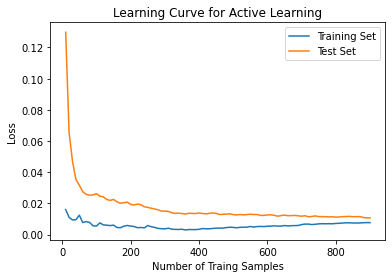

In [ ]:
plt.plot(np.linspace(10, 900, 90), active_mean.iloc[0], label = "Training Set")
plt.plot(np.linspace(10, 900, 90), active_mean.iloc[1], label = "Test Set")
plt.xlabel("Number of Traing Samples")
plt.ylabel("Loss")
plt.title("Learning Curve for Active Learning")
plt.legend(loc="best")
plt.show()